In [106]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itertools
from scipy.fft import fft, fftfreq
from copy import deepcopy 

In [146]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import hypyp
from hypyp.signal import SynteticSignal
from hypyp.plots import (
    spectrogram_plot,
    spectrogram_plot_period,
    plot_coifs,
    plot_coefs,
    plot_im_diff,
    plot_line,
    plot_S12,
    plot_times,
    plot_spectrogram_periods
)
from hypyp.fnirs_tools import (
    xwt_coherence_morl,
    smoothing
)
from hypyp.fnirs_tools_orig import (
    xwt_coherence_morl_orig
)

import pywt
import pycwt


The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


## Load snirfs

In [110]:
fname1 = '../data/sub-110_session-1_pre_raw.fif'
fname2 = '../data/sub-110_session-1_pre_raw.fif'

chs1 = ["S4_D4 hbo"] 
chs2 = ["S7_D6 hbo"]

#set events
tmin = 0 
tmax = 300
baseline = (0, 0)

from hypyp.fnirs import Subject, DyadFNIRS

dyad = DyadFNIRS(
    Subject().load_snirf_file(fname1).set_best_ch_names(chs1),
    Subject().load_snirf_file(fname2).set_best_ch_names(chs2)
).load_epochs(tmin, tmax, baseline)




Opening raw data file ../data/sub-110_session-1_pre_raw.fif...
    Range : 0 ... 5579 =      0.000 ...  1115.800 secs
Ready.
Reading 0 ... 5579  =      0.000 ...  1115.800 secs...


Opening raw data file ../data/sub-110_session-1_pre_raw.fif...
    Range : 0 ... 5579 =      0.000 ...  1115.800 secs
Ready.
Reading 0 ... 5579  =      0.000 ...  1115.800 secs...
Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


## Sine waves

Using data from preloaded Raw for 4 events and 1501 original time points ...
1 bad epochs dropped


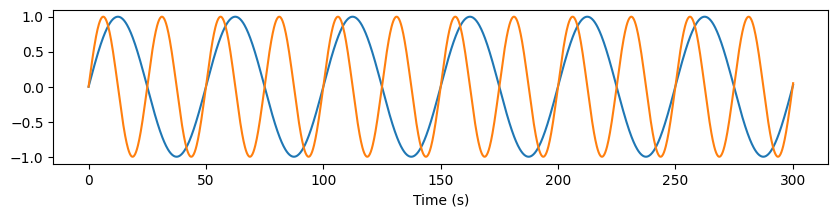

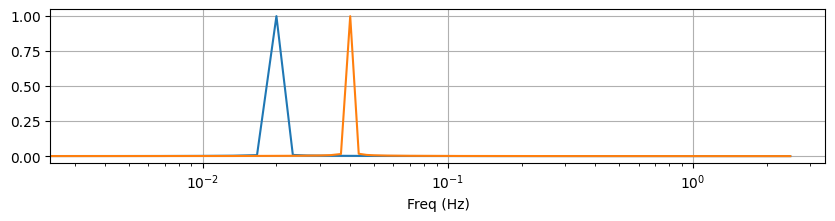

In [111]:

# take N from real data
N = len(dyad.s1.epochs.get_data()[0,0,:]) # N = 1501
sfreq = dyad.s1.epochs.info['sfreq'] # 5.0
period = 1 / sfreq
signal_freqs = [0.02, 0.04]
#signal_freqs = [1/50, 1/25]

signals = [SynteticSignal(tmax=N/sfreq, n_points=N).add_sin(signal_freq) for signal_freq in signal_freqs]

plt.figure(figsize=(10, 2))
[sig.plot() for sig in signals]
plt.show()

plt.figure(figsize=(10,2))
[sig.plot_fft() for sig in signals]
plt.grid()
plt.show()


## CWT
Continuous Wavelet Transform

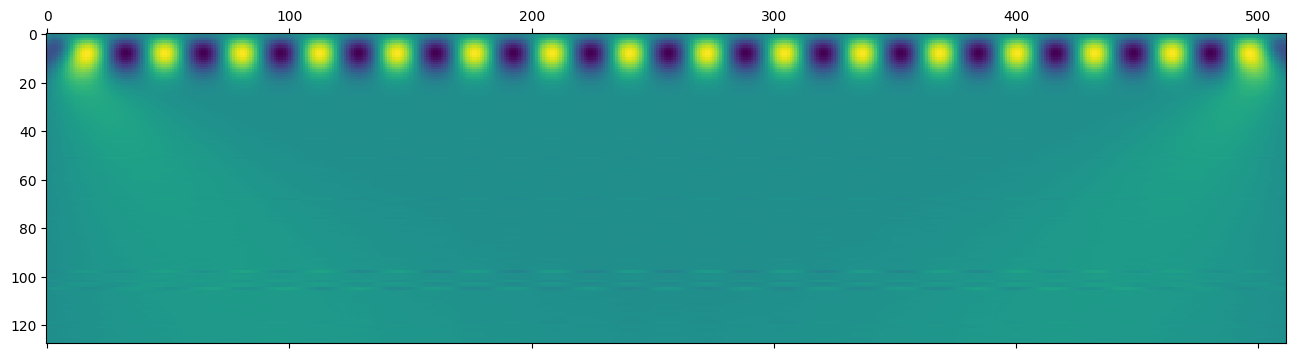

In [112]:
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef)
plt.show()

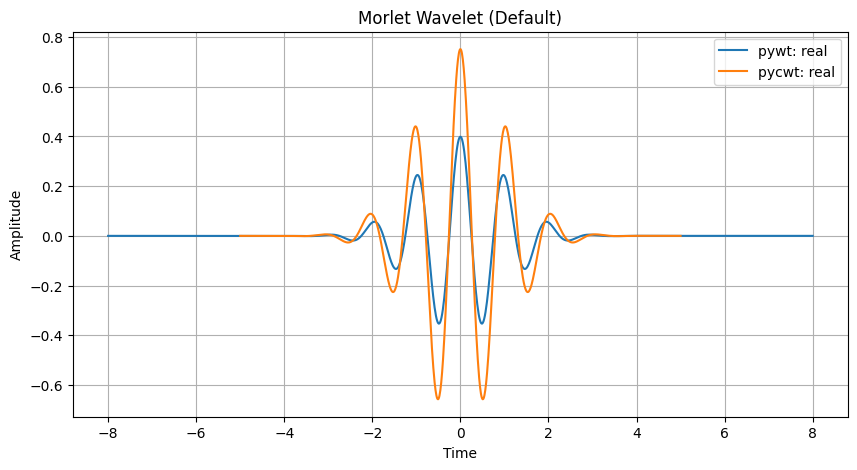

In [113]:
# pycwt.cwt
# Define the range of time values

[psi_pywt, x_pwtw] = pywt.ContinuousWavelet('cmor2, 1').wavefun(10)

morlet_wavelet_pycwt = pycwt.wavelet.Morlet()

# Calculate the wavelet values
t_pycwt = np.linspace(-5, 5, 1000)
wavelet_values_pycwt = morlet_wavelet_pycwt.psi(t_pycwt)

# Plot the wavelet
plt.figure(figsize=(10, 5))
plt.plot(x_pwtw, np.real(psi_pywt), label="pywt: real")
#plt.plot(x, np.imag(psi_pywt), label="pywt: imag")
plt.plot(t_pycwt, wavelet_values_pycwt.real, label='pycwt: real')
#plt.plot(t, wavelet_values.imag, label='pycwt: imag')
plt.title('Morlet Wavelet (Default)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()



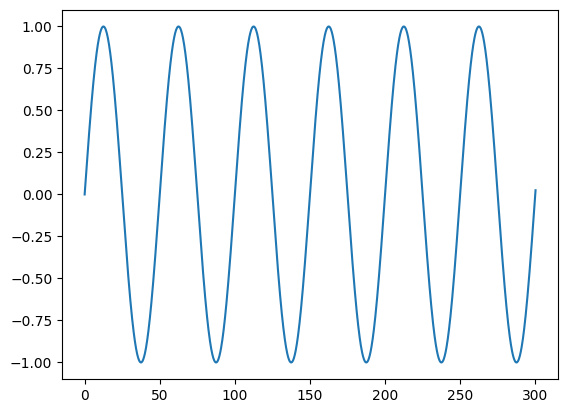

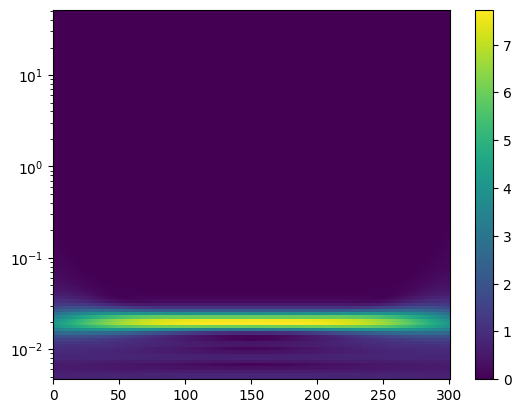

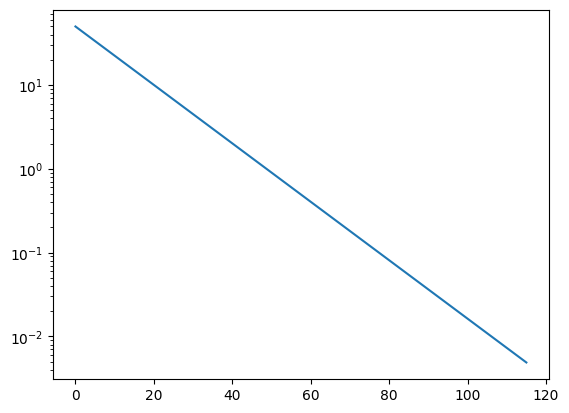

In [114]:
# pywt.cwt

scales = np.geomspace(0.1, 1024, num=116)
#sig = SynteticSignal(tmax=N/sfreq, n_points=N).add_sin(0.02).add_sin(0.04).add_noise()
sig = SynteticSignal(tmax=N/sfreq, n_points=N).add_sin(0.02)
W_pywt, freqs_pywt = pywt.cwt(
    sig.y,
    scales,
    #'gaus1'
    'cmor2, 1',
    sampling_period=1/sig.sample_rate
)

plt.plot(sig.times_vec, sig.y)
plt.show()
#plt.matshow(np.real(W))
#plt.show()
#plt.matshow(np.imag(W))
#plt.show()
plt.figure()
plt.pcolormesh(sig.times_vec, freqs_pywt, np.abs(W_pywt), cmap='viridis')
plt.colorbar()
plt.yscale('log')
plt.show()

plt.plot(freqs_pywt)
plt.yscale('log')



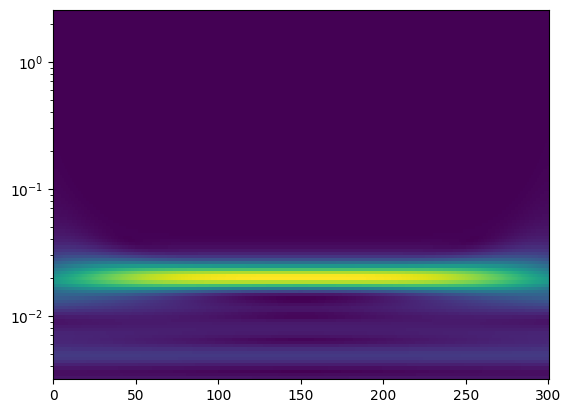

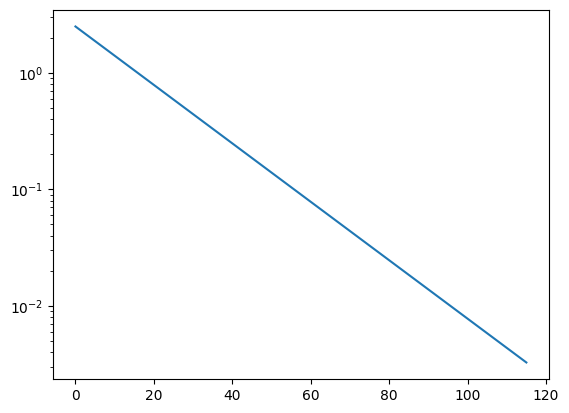

In [115]:

sig = SynteticSignal(tmax=N/sfreq, n_points=N).add_sin(0.02)
W_pycwt, sj, freqs_pycwt, coi_pycwt, fft, fftfreqs = pycwt.cwt(
    sig.y,
    1/sig.sample_rate
)

#plt.matshow(np.real(W_pycwt))
#plt.show()
#plt.matshow(np.imag(W_pycwt))
#plt.show()
plt.pcolormesh(sig.x, freqs_pycwt, np.abs(W_pycwt))
plt.yscale('log')
plt.show()

plt.plot(freqs_pycwt)
plt.yscale('log')


## WCT

In [224]:
import matplotlib.cm as cm

items = []

#tracers = [dict() for _ in range(3)]
tracers = [dict() for _ in range(2)]

#wct_morlet = xwt_coherence_morl_orig(signals[0].y, signals[1].y, sample_rate, tracer=tracers[0])
#wct, times, freq, coif = deepcopy(wct_morlet)
#items.append(dict(
#    wct=wct,
#    times=times,
#    freq=freq,
#    coif=coif,
#))

# Mega HACK, use the tracer to get the W1 and W2
tracer_hack = dict()
_ = pycwt.wct(
    signals[0].y,
    signals[1].y,
    dt=1/sfreq,
    sig=False,
    tracer=tracer_hack
)

wct, times, freq, coif = xwt_coherence_morl(
    signals[0].y,
    signals[1].y,
    dt=1/sfreq,
    tracer=tracers[0],
    wavelet_pywct=pycwt.Morlet(),
    W1_pywct=tracer_hack['W1'],
    W2_pywct=tracer_hack['W2'],
    freq_pywct=tracer_hack['freq'],
)
items.append(dict(
    wct=wct,
    times=times,
    freq=freq,
    coif=coif,
    dt=1/sfreq,
    dj=1/12,
))

wct_pycwt, aWCT, coi_pycwt, freqs_pycwt, sig = pycwt.wct(
    signals[0].y,
    signals[1].y,
    dt=1/sfreq,
    sig=False,
    tracer=tracers[1]
)
items.append(dict(
    wct=wct_pycwt,
    times=times, # this does not come from pycwt.wct
    freq=freqs_pycwt,
    coif=coif,
    dt=1/sfreq,
    dj=1/12,
))

plot_line(tracers, 'scales', 'scales (sj)', use_log_scale=True)
plot_line(tracers, 'freq', 'frequencies', use_log_scale=True)
#plot_im(tracers, 'S1')
#plot_im(tracers, 'S2')
#plot_S12(tracers)
plot_coefs(tracers, 'W1', 'W1 magnitude')
plot_coefs(tracers, 'W2', 'W2 magnitude')
plot_coefs(tracers, 'W12', 'W12 magnitude')
plot_coefs(tracers, 'S1', 'S1 magnitude')
plot_coefs(tracers, 'S2', 'S2 magnitude')
plot_coefs(tracers, 'S12', 'S12 magnitude')
#plot_im_diff(tracers[0]['S1'], tracers[1]['S1'], 'S1: ours wct minus pycwt.wct')
#plot_im_diff(tracers[1]['S2'], tracers[2]['S2'], 'S2: ours wct minus pycwt.wct')
#plot_coifs(items)
#plot_times(items)
plot_spectrogram_periods(items)
plot_line([dict(y=signals[0].y+signals[1].y) for _ in range(2)], 'y', 'signal')

UnboundLocalError: cannot access local variable 'freqs1' where it is not associated with a value

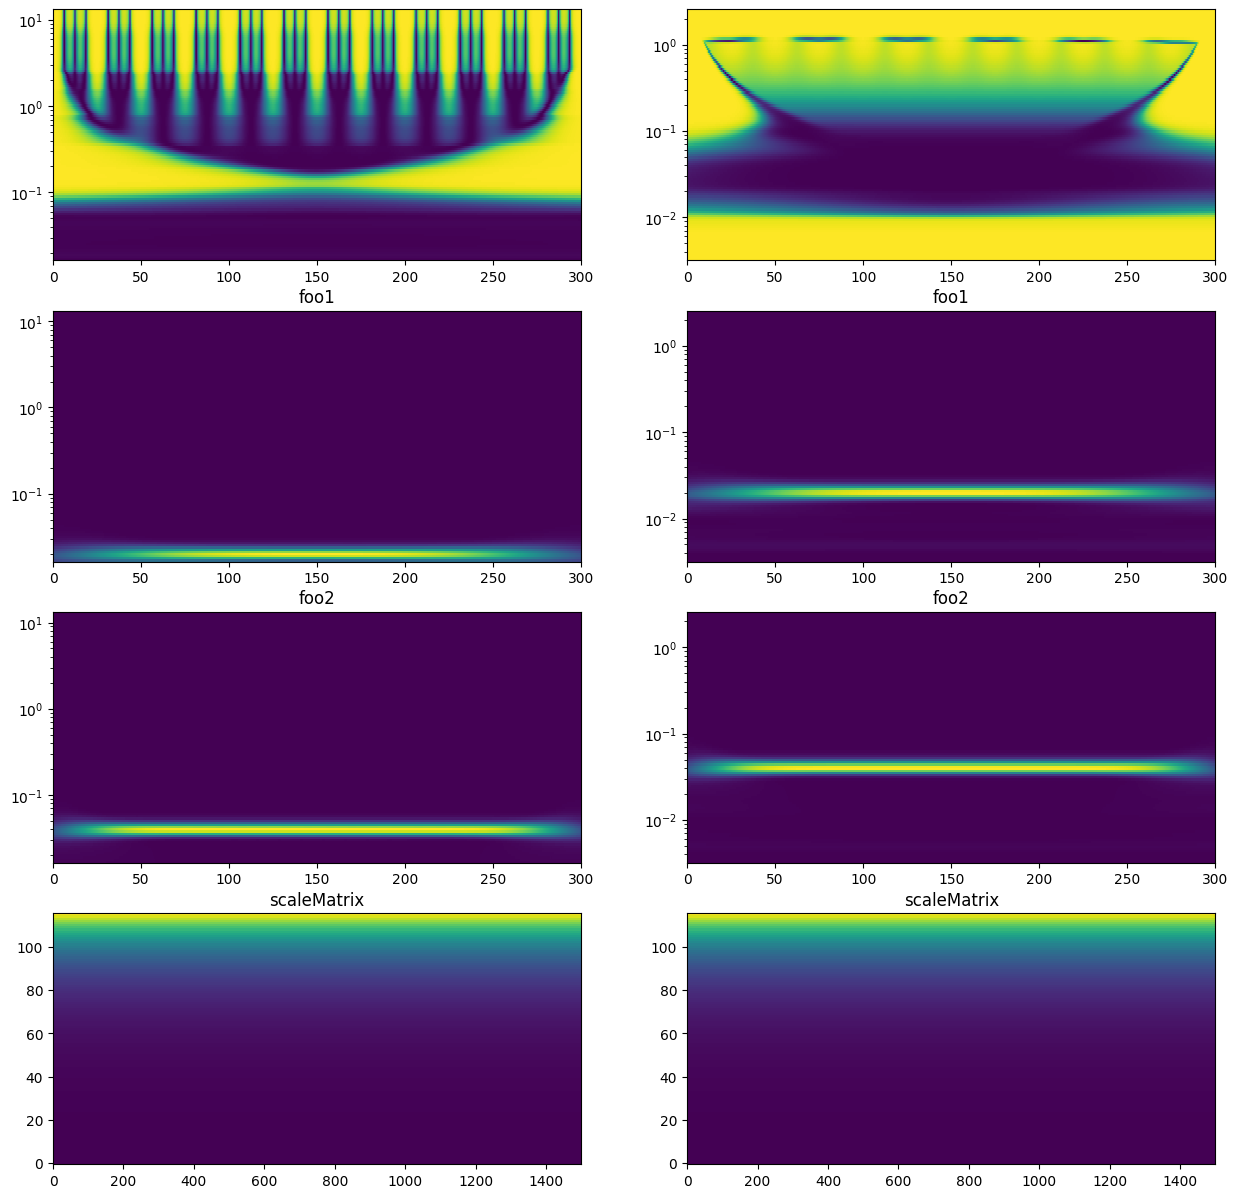

In [220]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

for i, item in enumerate(items):
    tracer = tracers[i]
    #wct = item['wct']
    #wct = np.abs(tracer['S12']) ** 2 / (tracer['S1'] * tracer['S2'])
    scaleMatrix = np.ones([1, N]) * tracer['scales'][:, None]
    #S1 = smoothing(np.abs(tracer['W1']) ** 2 / scaleMatrix, tracer['scales'], item['dj'])
    #S2 = smoothing(np.abs(tracer['W2']) ** 2 / scaleMatrix, tracer['scales'], item['dj'])
    #S12 = smoothing(tracer['W12'] / scaleMatrix, tracer['scales'], item['dj'])
    foo1 = np.abs(tracer['W1']) ** 2
    foo2 = np.abs(tracer['W2']) ** 2
    foo12 = tracer['W12']
    S1 = pycwt.Morlet().smooth(foo1 / scaleMatrix, item['dt'], item['dj'], tracer['scales'])
    S2 = pycwt.Morlet().smooth(foo2 / scaleMatrix, item['dt'], item['dj'], tracer['scales'])
    S12 = pycwt.Morlet().smooth(foo12 / scaleMatrix, item['dt'], item['dj'], tracer['scales'])
    wct = np.abs(S12) ** 2 / (S1 * S2)
    ax = axes[0, i]
    ax.pcolormesh(item['times'], item['freq'], wct)
    ax.set_yscale('log')

    ax = axes[1, i]
    ax.pcolormesh(item['times'], item['freq'], foo1)
    ax.set_yscale('log')
    ax.title.set_text('foo1')

    ax = axes[2, i]
    ax.pcolormesh(item['times'], item['freq'], foo2)
    ax.set_yscale('log')
    ax.title.set_text('foo2')

    ax = axes[3, i]
    im = ax.pcolormesh(np.arange(0, len(item['times'])),np.arange(0, len(item['freq'])), scaleMatrix)
    # fig.colorbar(im, cax=ax, orientation='vertical')
    #ax.set_yscale('log')
    ax.title.set_text('scaleMatrix')
plt.show() 

# For reference
#items.append(dict(
#    wct=wct_pycwt,
#    times=times, # this does not come from pycwt.wct
#    freq=freqs_pycwt,
#    coif=coif,
#))
